[2500, 1875, 1406, 1054, 791, 593, 444, 333, 250, 187, 140, 105, 79, 59, 44, 33, 25, 18, 14, 10, 7, 5, 4, 3, 2, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
50
Total nodes: 9984
Average degree: 2.976

=== Part (c): Random vaccination ===
ρ = 0.00: Peak I = 0.0661, Final R = 0.3550
ρ = 0.30: Peak I = 0.0426, Final R = 0.3901
ρ = 0.50: Peak I = 0.0296, Final R = 0.4153
ρ = 0.70: Peak I = 0.0189, Final R = 0.4424
ρ = 0.90: Peak I = 0.0109, Final R = 0.4726
ρ = 0.95: Peak I = 0.0095, Final R = 0.4809
ρ = 0.99: Peak I = 0.0095, Final R = 0.4878

=== Part (d): Targeted vaccination (highest degree) ===
ρ = 0.00: Peak I = 0.0661, Final R = 0.3550
ρ = 0.30: Peak I = 0.0196, Final R = 0.2934
ρ = 0.50: Peak I = 0.0095, Final R = 0.2619
ρ = 0.70: Peak I = 0.0094, Final R = 0.2977
ρ = 0.90: Peak I = 0.0092, Final R = 0.3696
ρ = 0.95: Peak I = 0.0092, Final R = 0.3886
ρ = 0.99: Peak I = 0.0092, Final R = 0.4039


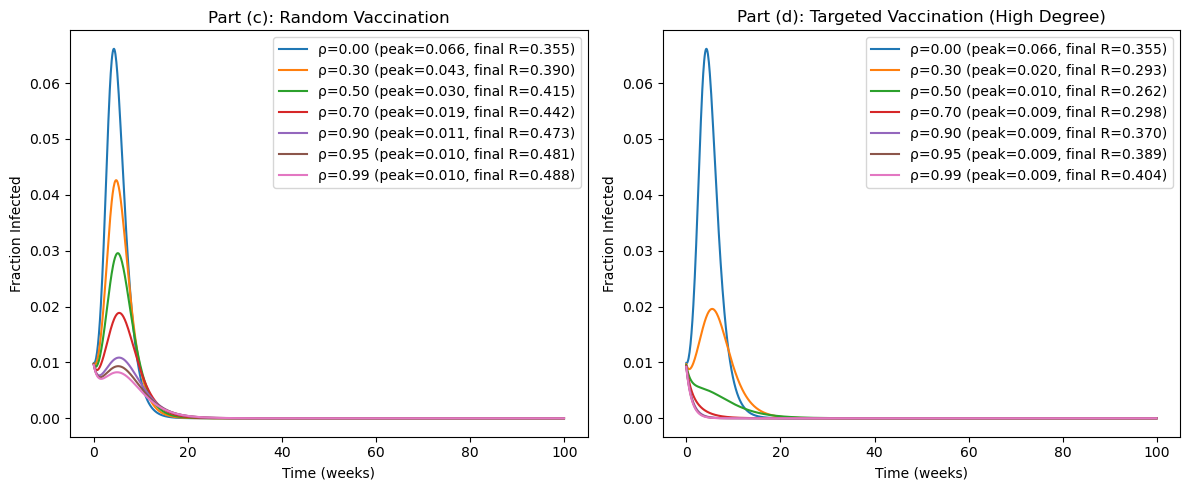


=== Summary ===

Minimum ρ to keep peak I < 0.01:
  Random vaccination: ρ ≥ 0.939
  Targeted vaccination: ρ ≥ 0.408

Targeted vaccination is 2.30x more efficient!


In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Parameters from the problem
beta = 0.3  # transmission rate (week^-1)
alpha = 1.0  # recovery rate (week^-1)
tmax = 100 # 500 in original notebook but we have higher transmission rate
h = 0.1  # timestep

# Geometric degree distribution: p_k = p(1-p)^k with p = 1/4 per assignment
p = 0.25
max_k = 50  # maximum degree to consider

# Generate geometric degree distribution
degree_freq = []
total_nodes = 10000  # assume 10,000 nodes - LHD's is almost 7k so I just round up


for k in range(max_k):
    p_k = p * (1 - p)**k
    n_k = total_nodes * p_k
    degree_freq.append(int(n_k))

print(degree_freq)
print(len(degree_freq))

# borrowed from MOCS_heterogeneous_meanfield.ipynb
G_deg_sum = [a * b for a, b in zip(degree_freq, range(0, len(degree_freq)))]
total_degree = sum(G_deg_sum)
N = sum(degree_freq)
avg_k = total_degree / N if N > 0 else 0

print(f"Total nodes: {N}")
print(f"Average degree: {avg_k:.3f}")


# replace with Theoretical work done in parts a and b for SIS
# These are SIR but the idea is to have a framework for c and d
def ODES(S, I, R, beta, alpha, k, theta):
    dS = -beta * k * theta * S
    dI = beta * k * theta * S - alpha * I
    dR = alpha * I
    return dS, dI, dR

# Function to run HMF simulation with vaccination
def run_hmf_vaccination(rho, vaccinate_high_degree=False, vaccination_fraction=0.4):
    """
    Run heterogeneous mean-field model with vaccination
    
    rho: vaccination efficacy (0 to 1)
    vaccinate_high_degree: if True, vaccinate highest degree nodes; if False, random
    vaccination_fraction: fraction of population to vaccinate (default 0.4)
    """
    
    # Initial conditions
    I0 = 0.01
    S0 = 1.0 - I0
    R0 = 0.0
    
    Sk = np.zeros(len(degree_freq))
    Ik = np.zeros(len(degree_freq))
    Rk = np.zeros(len(degree_freq))
    
    # Initialize populations
    for k in range(len(degree_freq)):
        Sk[k] = degree_freq[k] * S0
        Ik[k] = degree_freq[k] * I0
        Rk[k] = degree_freq[k] * R0
    
    # Apply vaccination
    if vaccinate_high_degree:
        # Part (d): Vaccinate 40% of highest degree nodes
        total_to_vaccinate = N * vaccination_fraction
        vaccinated_count = 0
        
        # Start from highest degree and work down
        for k in range(len(degree_freq)-1, -1, -1):
            if vaccinated_count >= total_to_vaccinate:
                break
            
            nodes_to_vaccinate = min(degree_freq[k], total_to_vaccinate - vaccinated_count)
            # Vaccination moves nodes from S to R with efficacy rho
            Sk[k] -= nodes_to_vaccinate * S0 * rho
            Rk[k] += nodes_to_vaccinate * S0 * rho
            vaccinated_count += nodes_to_vaccinate
    else:
        # Part (c): Random vaccination - proportional across all degrees
        for k in range(len(degree_freq)):
            nodes_to_vaccinate = degree_freq[k] * vaccination_fraction
            # Vaccination moves nodes from S to R with efficacy rho
            Sk[k] -= nodes_to_vaccinate * S0 * rho
            Rk[k] += nodes_to_vaccinate * S0 * rho
    
    # Run Euler's method - borrowed from MOCS_heterogeneous_meanfield.ipynb
    res = []
    T = np.arange(0, tmax/h)
    
    for t in T:
        # Calculate the mean-field (theta = probability a random edge points to infected node)
        theta = 0.0
        for k in range(len(degree_freq)):
            theta += k * Ik[k] / total_degree if total_degree > 0 else 0
        
        # Aggregate global quantities
        S = 0.0
        I = 0.0
        R = 0.0
        
        # # Run Euler's method for all degree classes k
        # YES, THESE ARE SIR - THINKING of these as equations to get the code working
        for k in range(len(degree_freq)):
            delta_Sk, delta_Ik, delta_Rk = ODES(Sk[k], Ik[k], Rk[k], beta, alpha, k, theta)
            # Update variables
            Sk[k] += delta_Sk * h
            Ik[k] += delta_Ik * h
            Rk[k] += delta_Rk * h
            
            # Accumulate global quantities
            S += Sk[k]
            I += Ik[k]
            R += Rk[k]
        
        res.append((S/N, I/N, R/N))
    
    # Unpack results
    St, It, Rt = map(np.array, zip(*res))
    return h*T, St, It, Rt

# Part (c): Test different values of rho with RANDOM vaccination
print("\n=== Part (c): Random vaccination ===")
rho_values = [0.0, 0.3, 0.5, 0.7, 0.9, 0.95, 0.99]

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
for rho in rho_values:
    T, St, It, Rt = run_hmf_vaccination(rho, vaccinate_high_degree=False)
    peak_I = np.max(It)
    final_R = Rt[-1]
    plt.plot(T, It, label=f'ρ={rho:.2f} (peak={peak_I:.3f}, final R={final_R:.3f})')
    print(f"ρ = {rho:.2f}: Peak I = {peak_I:.4f}, Final R = {final_R:.4f}")

plt.xlabel('Time (weeks)')
plt.ylabel('Fraction Infected')
plt.title('Part (c): Random Vaccination')
plt.legend()

# Part (d): Test different values of rho with TARGETED vaccination
print("\n=== Part (d): Targeted vaccination (highest degree) ===")

plt.subplot(1, 2, 2)
for rho in rho_values:
    T, St, It, Rt = run_hmf_vaccination(rho, vaccinate_high_degree=True)
    peak_I = np.max(It)
    final_R = Rt[-1]
    plt.plot(T, It, label=f'ρ={rho:.2f} (peak={peak_I:.3f}, final R={final_R:.3f})')
    print(f"ρ = {rho:.2f}: Peak I = {peak_I:.4f}, Final R = {final_R:.4f}")

plt.xlabel('Time (weeks)')
plt.ylabel('Fraction Infected')
plt.title('Part (d): Targeted Vaccination (High Degree)')
plt.legend()

plt.tight_layout()
plt.savefig('vaccination_comparison.png', dpi=150, bbox_inches='tight')
plt.show()

# Summary: Find minimum rho to eradicate outbreak (peak I < some threshold, e.g., 0.01)
print("\n=== Summary ===")
threshold = 0.01

rho_fine = np.linspace(0, 1, 50)
min_rho_random = None
min_rho_targeted = None

for rho in rho_fine:
    T, St, It, Rt = run_hmf_vaccination(rho, vaccinate_high_degree=False)
    if np.max(It) < threshold and min_rho_random is None:
        min_rho_random = rho
    
    T, St, It, Rt = run_hmf_vaccination(rho, vaccinate_high_degree=True)
    if np.max(It) < threshold and min_rho_targeted is None:
        min_rho_targeted = rho

print(f"\nMinimum ρ to keep peak I < {threshold}:")
print(f"  Random vaccination: ρ ≥ {min_rho_random:.3f}")
print(f"  Targeted vaccination: ρ ≥ {min_rho_targeted:.3f}")
print(f"\nTargeted vaccination is {min_rho_random/min_rho_targeted:.2f}x more efficient!")